# Simple RAG - Retrieval Augmented Generation

In [1]:
import os

os.environ["OPENAI_API_KEY"] = 'sk-***'

## Setup / Grabbing Documents

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
import uuid
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512, chunk_overlap=128
)

doc_splits = text_splitter.split_documents(docs_list)


for doc in doc_splits:
    doc.metadata["id"] = str(uuid.uuid4())

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(model="text-embedding-3-small")
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
num_docs = len(vectorstore._collection.get(include=["documents"])["documents"])
print("Total documents:", num_docs)


Total documents: 92


In [5]:
question = "What is few-shot learning?"
docs = retriever.get_relevant_documents(question)
for doc in docs:
    print(doc.page_content[:50], '...', doc.metadata['source'])

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_67912/2952994269.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


Some researchers tried Q-Learning to do sample sel ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
Choose examples that are semantically similar to t ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
Few-shot CoT. It is to prompt the model with a few ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
Text: despite all evidence to the contrary, this c ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/


## Retrieval Grader

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with structured output
llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)


# Prompt
system = """Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader  # llm + prompt

for doc in docs:
    doc_txt = doc.page_content
    print(retrieval_grader.invoke({"question": question, "document": doc_txt}), doc_txt[:50], '...', doc.metadata['source'])

binary_score='yes' Some researchers tried Q-Learning to do sample sel ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
binary_score='no' Choose examples that are semantically similar to t ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
binary_score='yes' Few-shot CoT. It is to prompt the model with a few ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
binary_score='no' Text: despite all evidence to the contrary, this c ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/


## Generate Compoments

In [7]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")
for message in prompt.messages:
    print(type(message))
    print(message.prompt.template)
    print('-----')

<class 'langchain_core.prompts.chat.HumanMessagePromptTemplate'>
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
-----


/Users/sinanozdemir/Teaching/Pearson/oreilly-ai-agents/myenv/lib/python3.13/site-packages/langsmith/client.py:280: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [8]:
# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

Few-shot learning is a machine learning approach where a model is trained to perform tasks using only a small number of examples. It often involves providing the model with a few demonstrations or prompts to guide its understanding of the task. This method is particularly useful in scenarios where labeled data is scarce or expensive to obtain.


## Graph State

In [9]:
from typing import List

from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        something_relevant: if any of the retrieved documents are relevant
    """

    question: str
    generation: str
    documents: List[str]
    something_relevant: bool

## The Nodes

In [10]:
# from langchain.schema import Document

def retrieve(state):
    print(state)
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": format_docs(documents), "question": question})
    return {"generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        print(d.metadata['source'], f'Grade: {grade}')
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
                
    if len(filtered_docs) == 0:
        something_relevant = False
        print("---GRADE: DOCUMENTS NOT RELEVANT---")
    else:
        something_relevant = True
    return {"documents": filtered_docs, "something_relevant": something_relevant}


## Building the Graph

In [11]:
from langgraph.graph import END, START, StateGraph

workflow = StateGraph(GraphState)

# Define nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# Gating logic
def pass_fail_gate(state):
    if state["something_relevant"]:
        return "something_relevant"
    return "nothing_relevant"

workflow.add_conditional_edges(
    "grade_documents",
    pass_fail_gate,
    {
        "something_relevant": "generate",
        "nothing_relevant": END,
    },
)

workflow.add_edge("generate", END)

# Compile graph
app = workflow.compile()


## Running the Graph

In [12]:
def run_graph_and_get_state(app, inputs: dict):
    full_state = dict(inputs)  # seed with initial input

    for output in app.stream(inputs):
        for key, value in output.items():
            print(f"Node '{key}':")
            full_state.update(value)

    print("Final generation:", full_state.get("generation"))
    print("Documents used:", len(full_state.get("documents", [])))
    return full_state


### "What on earth is few shot learning?"

In [13]:
run_graph_and_get_state(app, {"question": "What on earth is few shot learning?"})

{'question': 'What on earth is few shot learning?'}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION---
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: yes
---GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: yes
---GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: no
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: no
Node 'grade_documents':
---GENERATE---
Node 'generate':
Final generation: Few-shot learning is a machine learning approach where a model is trained to perform tasks using only a small number of examples. It often involves providing a few demonstrations in the prompt to help the model understand the task better. This method can be resource-intensive and may limit input length due to token usage.
Documents used: 2


{'question': 'What on earth is few shot learning?',
 'documents': [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'id': 'b21a6ba7-b379-4a2f-9aa2-64a25205a3aa', 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'title': "Prompt Engineering | Lil'Log"}, page_content='Some researchers tried Q-Learning to do sample selection. (Zha

### "How to make good inputs to AI?"

In [14]:
run_graph_and_get_state(app, {"question": "How to make good inputs to AI?"})

{'question': 'How to make good inputs to AI?'}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION---
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: no
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: no
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: no
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: no
---GRADE: DOCUMENTS NOT RELEVANT---
Node 'grade_documents':
Final generation: None
Documents used: 0


{'question': 'How to make good inputs to AI?',
 'documents': [],
 'something_relevant': False}

### "How big is the moon?"

In [15]:
run_graph_and_get_state(app, {"question": "How big is the moon?"})

{'question': 'How big is the moon?'}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION---
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: no
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: no
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: no
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: no
---GRADE: DOCUMENTS NOT RELEVANT---
Node 'grade_documents':
Final generation: None
Documents used: 0


{'question': 'How big is the moon?',
 'documents': [],
 'something_relevant': False}

## Visualize the Graph

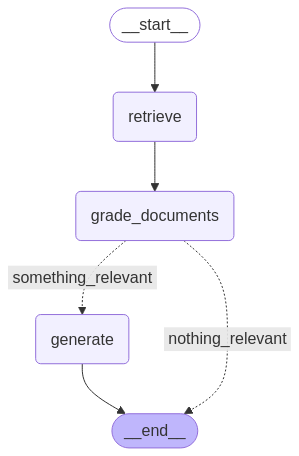

In [16]:
# Visualize our graph
from IPython.display import Image, display
for i in range(100):
    try:
        display(Image(app.get_graph().draw_mermaid_png()))
        break
    except Exception:
        pass

In [17]:
# if the above fails try this (requires grandalf)

print(app.get_graph().draw_ascii())

           +-----------+       
           | __start__ |       
           +-----------+       
                  *            
                  *            
                  *            
            +----------+       
            | retrieve |       
            +----------+       
                  *            
                  *            
                  *            
        +-----------------+    
        | grade_documents |    
        +-----------------+    
           ...        ...      
          .              .     
        ..                ...  
+----------+                 . 
| generate |              ...  
+----------+             .     
           ***        ...      
              *      .         
               **  ..          
            +---------+        
            | __end__ |        
            +---------+        


# Testing our Components

## Creating Synthetic Questions

In [18]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

class MultihopOutput(BaseModel):
    fact1: str = Field(description="A fact found in document 1.")
    fact2: str = Field(description="A fact found in document 2.")
    multihop_question: str = Field(description="A question that requires both facts to answer.")
    multihop_answer: str = Field(description="The answer to the question that requires both facts to answer.")
    status: str = Field(description='"verified" if the question/answer are valid. "unverified" otherwise')

# LLM setup
llm = ChatOpenAI(model="gpt-4o", temperature=0.7).with_structured_output(MultihopOutput)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You're a question synthesizer for multihop QA datasets."),
    ("human", 
     "Document 1:\n{doc1}\n\nDocument 2:\n{doc2}\n\n"
     "1. First, give one stand-alone factual statement (requiring only the given document) from each document.\n"
     "2. Then, write one multihop question that requires *both* facts to answer.\n"
     "3. Then, write the answer to this question.\n"
     "4. Finally, Output \"verified\" if the question/answer are sensical given the context, and \"unverified\" otherwise."
     
     )
])

chain = prompt | llm


In [19]:
import random

def get_two_random_docs_with_ids(vectorstore):
    # Fetch documents, IDs come automatically (no include needed)
    result = vectorstore._collection.get(include=["documents", "metadatas"])  # works
    docs = result["documents"]
    ids = [m['id'] for m in result["metadatas"]]
    
    paired = list(zip(ids, docs))
    sampled = random.sample(paired, 2)
    
    return [{"id": id_, "text": doc} for id_, doc in sampled]


In [20]:
def generate_multihop_question(vectorstore):
    doc_output = get_two_random_docs_with_ids(vectorstore)
    synthetic_output = chain.invoke({
        "doc1": doc_output[0]['text'],
        "doc2": doc_output[1]['text'],
    })
    return synthetic_output, [doc_output[0]['id'], doc_output[1]['id']]


In [41]:
multi_hop_synthetic_question, docs = generate_multihop_question(vectorstore)
multi_hop_synthetic_question

(MultihopOutput(fact1='Zero-shot learning involves feeding the task text to the model and asking for results, without providing any examples.', fact2='Current agent systems rely on natural language as an interface between LLMs and external components, but the reliability of model outputs is questionable due to potential formatting errors and rebellious behavior.', multihop_question='How does zero-shot learning in prompt engineering relate to the reliability concerns of natural language interfaces in agent systems?', multihop_answer='Zero-shot learning involves providing task text without examples, which can exacerbate reliability concerns in natural language interfaces since the model may not have prior examples to ensure accurate or correctly formatted outputs, increasing the chance of errors or rebellious behavior.', status='verified'),
 ['45006fe3-7c03-43eb-8afd-bfeeaba94143',
  '07817322-609d-4d7b-bfab-408315f44429'])

In [52]:
print(f"Fact 1: {multi_hop_synthetic_question.fact1}")
print(f"Document 1: {docs[0]}")
print('-----')
print(f"Fact 2: {multi_hop_synthetic_question.fact2}")
print(f"Document 2: {docs[1]}")
print('-----')
print(f"Question: {multi_hop_synthetic_question.multihop_question}")
print(f"Probable Answer: {multi_hop_synthetic_question.multihop_answer}")

Fact 1: Zero-shot learning involves feeding the task text to the model and asking for results, without providing any examples.
Document 1: 45006fe3-7c03-43eb-8afd-bfeeaba94143
-----
Fact 2: Current agent systems rely on natural language as an interface between LLMs and external components, but the reliability of model outputs is questionable due to potential formatting errors and rebellious behavior.
Document 2: 07817322-609d-4d7b-bfab-408315f44429
-----
Question: How does zero-shot learning in prompt engineering relate to the reliability concerns of natural language interfaces in agent systems?
Probable Answer: Zero-shot learning involves providing task text without examples, which can exacerbate reliability concerns in natural language interfaces since the model may not have prior examples to ensure accurate or correctly formatted outputs, increasing the chance of errors or rebellious behavior.


In [22]:
from tqdm import tqdm
multihop_examples = []

for _ in tqdm(range(100)):
    try:
        output, ids = generate_multihop_question(vectorstore)
        result = {
            "fact1": output.fact1,
            "fact2": output.fact2,
            "multihop_question": output.multihop_question,
            "multihop_answer": output.multihop_answer,
            "status": output.status,
            "doc1": ids[0],
            "doc2": ids[1]
        }
        multihop_examples.append(result)
    except Exception as e:
        print(f"Failed on iteration with error: {e}")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:36<00:00,  2.76s/it]


In [23]:
import pandas as pd

synthetic_df = pd.DataFrame(multihop_examples)
synthetic_df.head()

,fact1,fact2,multihop_question,multihop_answer,status,doc1,doc2
0,The agent learns to call external APIs for ext...,The most common way to mitigate risks of adver...,How can an agent enhance its capability to han...,An agent can enhance its capability to handle ...,verified,98fe49c9-c33c-495c-924c-f29793030887,0fa3a5ac-f2a9-4c10-9672-d790be5e8be8
1,Document 1 mentions that adversarial attacks a...,Document 2 describes an optimization technique...,What method is used to improve the performance...,"The ARCA method, which maximizes the log-likel...",verified,9e55ea56-328e-43f7-b99e-0ff8e7c30a84,311c7373-92c1-410e-b246-065a9244e14e
2,FAISS applies vector quantization by partition...,Reflexion is a framework to equip agents with ...,How does FAISS's approach to vector quantizati...,FAISS's approach to vector quantization by ref...,verified,96716e56-81b7-4047-a9cb-989bdd8aa452,27d679b8-f9bc-4c80-9c2c-4f9162150e95
3,The architecture implementation process involv...,API calls are filtered based on their ability ...,How does the architecture implementation proce...,The architecture implementation process ensure...,verified,0a003a63-67cb-47a8-989c-32bec89c98fb,c44f0348-e3e0-47b3-a8ec-e082dd493531
4,AutoPrompt uses a gradient-based search strate...,"The document mentions terms like NLP, Language...",What search strategy does AutoPrompt use that ...,AutoPrompt uses a gradient-based search strate...,verified,9bae6291-afac-4081-837f-a4e3205ee638,73b8af8a-7b7d-4e39-b869-3c73b6336158


<Axes: xlabel='status'>

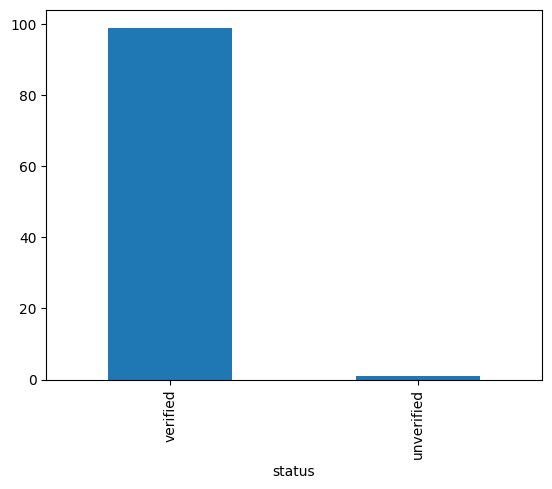

In [24]:
synthetic_df['status'].value_counts().plot(kind='bar')

## Grade our retriever + grader

In [25]:
synthetic_df = synthetic_df[synthetic_df['status'] == 'verified']

In [26]:
def grade_retrieval_for_row(row, retriever, retrieval_grader):
    question = row["multihop_question"]
    true_ids = set([row["doc1"], row["doc2"]])
    
    try:
        retrieved_docs = retriever.get_relevant_documents(question)
    except Exception as e:
        return {"error": str(e), "graded_docs": []}
    graded_docs = []
    retrieved_ids = set([doc.metadata.get("id") for doc in retrieved_docs])
    num_correct_documents_retrieved = len(true_ids & retrieved_ids)
    for doc in retrieved_docs:
        doc_id = doc.metadata.get("id")
        if not doc_id:
            continue
        score = retrieval_grader.invoke({
            "question": question,
            "document": doc.page_content
        })
        graded_docs.append({
            "doc_id": doc_id,
            "relevant_predicted": score.binary_score == 'yes',
            "relevant_actual": doc_id in true_ids
        })

    return {
        "question": question,
        "graded_docs": graded_docs,
        "num_correct_documents_retrieved": num_correct_documents_retrieved
    }


In [27]:
graded_results = []

for _, row in synthetic_df.iterrows():
    result = grade_retrieval_for_row(row, retriever, retrieval_grader)
    graded_results.append(result)


In [28]:
graded_results[0]

{'question': 'How can an agent enhance its capability to handle adversarial attacks using external information?',
 'graded_docs': [{'doc_id': '0fa3a5ac-f2a9-4c10-9672-d790be5e8be8',
   'relevant_predicted': False,
   'relevant_actual': True},
  {'doc_id': '30f273da-5f07-4d85-a442-d636f27c02a5',
   'relevant_predicted': False,
   'relevant_actual': False},
  {'doc_id': '4776eaf5-4b05-4437-bdfd-c7769c1031a9',
   'relevant_predicted': False,
   'relevant_actual': False},
  {'doc_id': 'ccff528d-6156-499a-ba87-daba791dad7d',
   'relevant_predicted': False,
   'relevant_actual': False}],
 'num_correct_documents_retrieved': 1}

In [29]:
def evaluate_grader_outputs(results):
    TP = FP = FN = TN = 0

    for row in results:
        for doc in row["graded_docs"]:
            actual = doc["relevant_actual"]
            predicted = doc["relevant_predicted"]

            if actual and predicted:
                TP += 1
            elif actual and not predicted:
                FN += 1
            elif not actual and predicted:
                FP += 1
            else:
                TN += 1

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    tpr = recall
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0

    return {
        "true_positives": TP,
        "false_positives": FP,
        "false_negatives": FN,
        "true_negatives": TN,
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy,
        "f1_score": f1,
        "true_positive_rate": tpr,
        "false_positive_rate": fpr,
    }

metrics = evaluate_grader_outputs(graded_results)
evaluation = {}
for k, v in metrics.items():
    evaluation[k] = v


In [30]:
evaluation

{'true_positives': 40,
 'false_positives': 76,
 'false_negatives': 70,
 'true_negatives': 210,
 'precision': 0.3448275862068966,
 'recall': 0.36363636363636365,
 'accuracy': 0.6313131313131313,
 'f1_score': 0.3539823008849558,
 'true_positive_rate': 0.36363636363636365,
 'false_positive_rate': 0.26573426573426573}

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_67912/237238012.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, ax=ax, palette="viridis")
/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_67912/237238012.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(metrics_to_plot, rotation=45, ha="right")  # Tilt x-axis labels


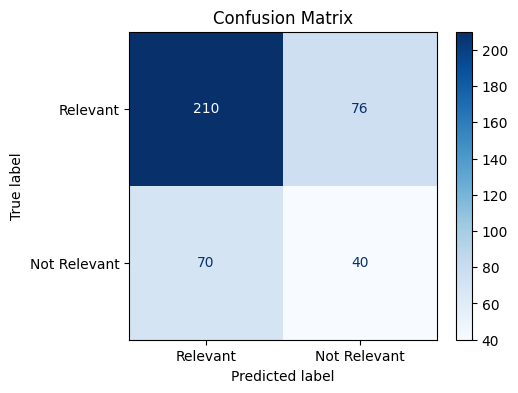

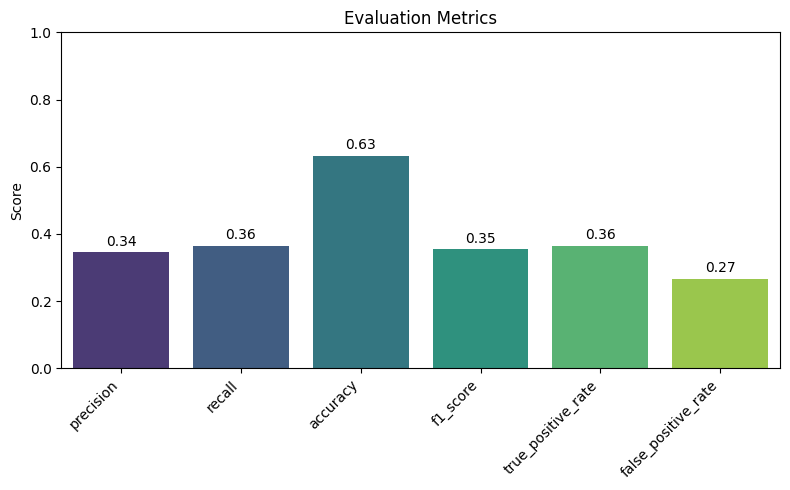

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_eval(evaluation):
    # Confusion matrix
    labels = ["Relevant", "Not Relevant"]
    y_true = [1]*evaluation["true_positives"] + [1]*evaluation["false_negatives"] + [0]*evaluation["false_positives"] + [0]*evaluation["true_negatives"]
    y_pred = [1]*evaluation["true_positives"] + [0]*evaluation["false_negatives"] + [1]*evaluation["false_positives"] + [0]*evaluation["true_negatives"]
    
    fig1, ax1 = plt.subplots(figsize=(5, 4))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax1, cmap="Blues", values_format="d")
    ax1.set_title("Confusion Matrix")
    # Re-plot the bar chart with tilted x-axis labels
    fig, ax = plt.subplots(figsize=(8, 5))
    metrics_to_plot = ["precision", "recall", "accuracy", "f1_score", "true_positive_rate", "false_positive_rate"]
    values = [evaluation[k] for k in metrics_to_plot]
    sns.barplot(x=metrics_to_plot, y=values, ax=ax, palette="viridis")
    ax.set_title("Evaluation Metrics")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    ax.set_xticklabels(metrics_to_plot, rotation=45, ha="right")  # Tilt x-axis labels
    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f"{v:.2f}", ha="center")
    
    plt.tight_layout()
    plt.show()

plot_eval(evaluation)

## Try a different embedder

In [32]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings

# Example: Using a better OpenAI model
# embedding_fn = OpenAIEmbeddings(model="text-embedding-3-large")

embedding_fn = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

vectorstore_two = Chroma.from_documents(
    documents=doc_splits,
    embedding=embedding_fn,
    collection_name="rag-chroma-mpnet",  # use a different name
)
retriever = vectorstore_two.as_retriever()

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_67912/750963962.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_fn = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
/Users/sinanozdemir/Teaching/Pearson/oreilly-ai-agents/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
graded_results_v2 = [grade_retrieval_for_row(row, retriever, retrieval_grader) for _, row in synthetic_df.iterrows()]
metrics_v2 = evaluate_grader_outputs(graded_results_v2)
evaluation_v2 = {}
for k, v in metrics_v2.items():
    evaluation_v2[k] = v


In [34]:
graded_results[0]

{'question': 'How can an agent enhance its capability to handle adversarial attacks using external information?',
 'graded_docs': [{'doc_id': '0fa3a5ac-f2a9-4c10-9672-d790be5e8be8',
   'relevant_predicted': False,
   'relevant_actual': True},
  {'doc_id': '30f273da-5f07-4d85-a442-d636f27c02a5',
   'relevant_predicted': False,
   'relevant_actual': False},
  {'doc_id': '4776eaf5-4b05-4437-bdfd-c7769c1031a9',
   'relevant_predicted': False,
   'relevant_actual': False},
  {'doc_id': 'ccff528d-6156-499a-ba87-daba791dad7d',
   'relevant_predicted': False,
   'relevant_actual': False}],
 'num_correct_documents_retrieved': 1}

In [35]:
graded_results_v2[0]

{'question': 'How can an agent enhance its capability to handle adversarial attacks using external information?',
 'graded_docs': [{'doc_id': '30f273da-5f07-4d85-a442-d636f27c02a5',
   'relevant_predicted': False,
   'relevant_actual': False},
  {'doc_id': '9e55ea56-328e-43f7-b99e-0ff8e7c30a84',
   'relevant_predicted': True,
   'relevant_actual': False},
  {'doc_id': 'cd5e7499-6f6f-4b1a-b6d7-188ef9451dc0',
   'relevant_predicted': False,
   'relevant_actual': False},
  {'doc_id': '5512fb2c-525f-4313-85a5-35bfe614b439',
   'relevant_predicted': False,
   'relevant_actual': False}],
 'num_correct_documents_retrieved': 0}

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_67912/237238012.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, ax=ax, palette="viridis")
/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_67912/237238012.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(metrics_to_plot, rotation=45, ha="right")  # Tilt x-axis labels


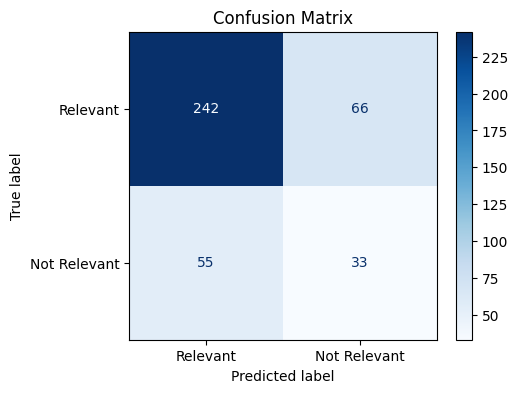

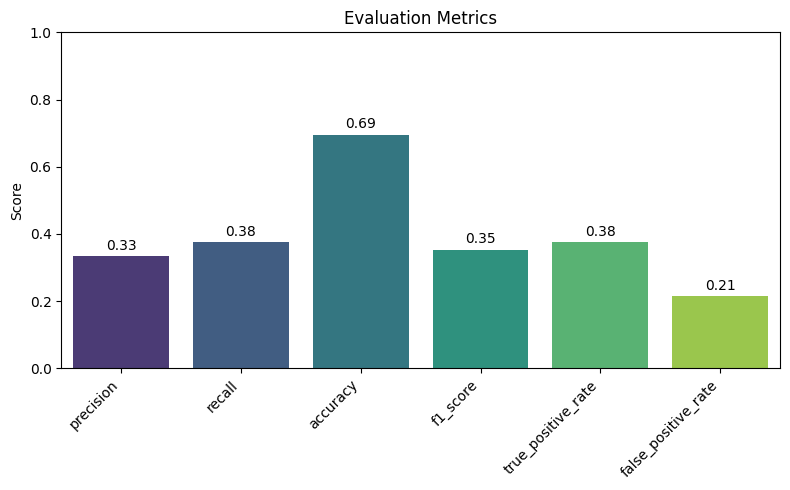

In [36]:
plot_eval(evaluation_v2)